In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

from joblib import delayed, Parallel

import itertools

from sklearn.decomposition import PCA

In [5]:
df = pd.read_csv('./dota2DatasetTrain_header_01.csv')
X = df.drop(['winning_team'], axis=1)
y = df['winning_team']

In [6]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

<Axes: xlabel='PC0', ylabel='PC1'>

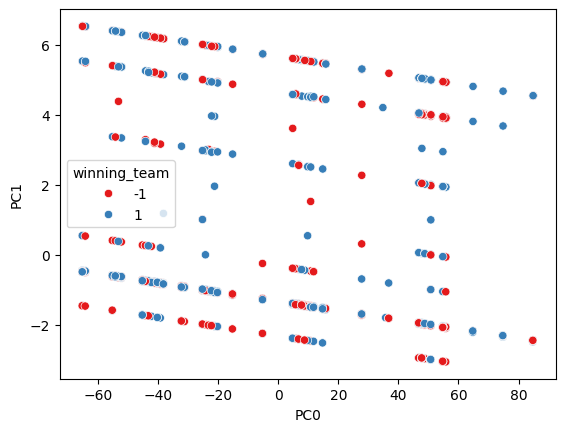

In [7]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

# KNN com validação cruzada em dois níveis

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

conf_matrix = None
acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {'n_neighbors' : range(1,30,2)}
    #instanciar um KNN com parametros padrão
    knn = KNeighborsClassifier()
    #instanciar um GridSearchCV com k2 vias.
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_macro')
    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    knn.fit(X_treino, y_treino)

    pred = knn.predict(X_teste)
    print(classification_report(y_teste, pred, zero_division=0))
    
    cm = confusion_matrix(y_teste, pred)
    if conf_matrix is None:
        conf_matrix = cm
    else:
        conf_matrix += cm

print('Matriz de confusão')
print(conf_matrix)    

              precision    recall  f1-score   support

          -1       0.50      0.45      0.47       439
           1       0.55      0.60      0.57       488

    accuracy                           0.53       927
   macro avg       0.53      0.53      0.52       927
weighted avg       0.53      0.53      0.53       927

              precision    recall  f1-score   support

          -1       0.44      0.38      0.41       439
           1       0.50      0.56      0.53       488

    accuracy                           0.48       927
   macro avg       0.47      0.47      0.47       927
weighted avg       0.47      0.48      0.47       927

              precision    recall  f1-score   support

          -1       0.56      0.48      0.52       439
           1       0.58      0.65      0.62       488

    accuracy                           0.57       927
   macro avg       0.57      0.57      0.57       927
weighted avg       0.57      0.57      0.57       927

              preci

# SVM com validação cruzada em um nível

In [12]:
from sklearn.svm import SVC

In [13]:
def selecionar_melhor_svm(Cs, Gammas, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for C in Cs:
        for gamma in Gammas:
            svm = SVC(C=C, gamma=gamma, kernel='rbf')
            svm.fit(X_treino, y_treino)
            pred = svm.predict(X_val)
            acuracias_val.append(accuracy_score(y_val, pred))

    melhor_valor = np.max(acuracias_val)
    melhor_C = Cs[np.argmax(acuracias_val) // len(Gammas)]
    melhor_gamma = Gammas[np.argmax(acuracias_val) % len(Gammas)]
    svm = SVC(C=melhor_C, gamma=melhor_gamma, kernel='rbf')
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_valor, melhor_C, melhor_gamma

In [14]:
#a validação cruzada será realizada em 10 vias.
k_vias = 10

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]
    
    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #valores de C e gamma a serem testados
    C_values = [0.1, 1, 10, 100, 1000]
    gamma_values = ['scale', 'auto', 2e-2, 2e-3, 2e-4]

    svm, melhor_valor, melhor_C, melhor_gamma = selecionar_melhor_svm(C_values, gamma_values, X_treino, X_val, y_treino, y_val)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, svm.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))

min: 0.55, max: 0.61, avg +- std: 0.58+-0.02


# Random Forest com validação cruzada em dois níveis

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

# usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

rf_conf_matrix = None
acuracias = []

# a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):

    # extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]

    # extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]

    # colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)

    # combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    # Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params={
        'criterion' : ['gini', 'entropy'], 
        'random_state' : [1], 
        'n_estimators': [100, 200, 500],
    }

    # instanciar um KNN com parametros padrão
    rf = RandomForestClassifier()

    # instanciar um GridSearchCV com k2 vias.
    rf = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits=k2), scoring='f1_weighted')
    
    # realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    rf.fit(X_treino, y_treino)

    # predizer os dados de teste usando o modelo treinado
    pred = rf.predict(X_teste)

    # calcular a acurácia do modelo na base de teste e imprimir
    print(classification_report(y_teste, pred))

    # calcular a matriz de confusão do modelo na base de teste e imprimir
    cm = confusion_matrix(y_teste, pred)
    if rf_conf_matrix is None:
        rf_conf_matrix = cm
    else:
        rf_conf_matrix += cm


print("Soma das matrizes de confusão:")
print(conf_matrix)


KeyboardInterrupt: 